In [5]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.regularizers as reg
import keras_tuner as kt
import numpy as np

import kaggle_functions as kaggle
import importlib
importlib.reload(kaggle);

In [2]:
train_dataset, valid_dataset, valid_labels = kaggle.load_train_as_dataset()
x_test_real = kaggle.load_test_set()

batch_size = 128
train_dataset_augmented, epoch_length = kaggle.augment_dataset(train_dataset, batch_size)

model_number = 'model3'

### GoogLeNet

In [3]:
class GoogLeNet(kt.HyperModel):
    def inception_layer(self, input, f1, f3_in, f3_out, f5_in, f5_out, pool_out, dropout=0):
        conv1 = layers.Conv2D(
            f1, kernel_size=(1,1), padding='same', 
            activation='relu', kernel_initializer='he_uniform')(input)
        
        conv3 = layers.Conv2D(
            f3_in, (1,1), padding='same', 
            activation='relu', kernel_initializer='he_uniform')(input)
        conv3 = layers.Conv2D(
            f3_out, kernel_size=(3,3), padding='same', 
            activation='relu', kernel_initializer='he_uniform')(conv3)
        
        conv5 = layers.Conv2D(
            f5_in, (1,1), padding='same', 
            activation='relu', kernel_initializer='he_uniform')(input)
        conv5 = layers.Conv2D(
            f5_out, kernel_size=(5,5), padding='same', 
            activation='relu', kernel_initializer='he_uniform')(conv5)
        
        pool = layers.MaxPooling2D((3,3), strides=(1,1), padding='same')(input)
        pool = layers.Conv2D(
            pool_out, kernel_size=(1,1), padding='same', 
            activation='relu', kernel_initializer='he_uniform')(pool)
        
        layer_out = layers.concatenate([conv1, conv3, conv5, pool])

        if dropout == 0:
            return layer_out
        else:
            return layers.Dropout(dropout)(layer_out)
    
    def maxpool_layer(self, input):
        return layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(input)

    def conv_layer(self, input, filter, kernel, stride=1):
        return layers.Conv2D(
            filters=filter, kernel_size=(kernel,kernel), 
            strides=(stride, stride), padding='same',
            kernel_initializer='he_uniform')(input)

    def dense_layer(self, input, size, l2_reg, dropout):
        dense = layers.Dense(
            size, activation='relu', kernel_initializer='he_uniform',
            kernel_regularizer=keras.regularizers.l2(l2_reg),
            bias_regularizer=keras.regularizers.l2(l2_reg))(input)
        return layers.Dropout(dropout)(dense)

    def build(self, hyperparameters):
        # Fixed hyperparameters
        l2_reg = 0.0025
        conv_dropout = 0.05
        dense_dropout = 0.75

        input_layer = layers.Input(shape=(96, 96, 1))

        # Input convolution
        # Local respnorm and Spatial Dropout added
        output = self.conv_layer(input_layer, 64, 7, 2)
        output = layers.BatchNormalization()(output)

        # Second input convolution
        output = self.conv_layer(output, 128, 3, 2)
        output = layers.BatchNormalization()(output)

        # Inception layers, level 1
        output = self.inception_layer(output, 64, 96, 128, 16, 32, 32, dropout=conv_dropout) #3a
        output = layers.BatchNormalization()(output)
        output = self.inception_layer(output, 128, 128, 192, 32, 96, 64, dropout=conv_dropout) #3b
        output = self.maxpool_layer(output)
        output = layers.BatchNormalization()(output)

        # Inception layers, level 2
        output = self.inception_layer(output, 192, 96, 208, 16, 48, 64, dropout=conv_dropout) #4a

        # Auxilliary prediction layer
        output = layers.AveragePooling2D(pool_size=(5,5), strides=(2,2))(output)
        output = layers.BatchNormalization()(output)
        output = self.conv_layer(output, 128, 1)
        output = layers.Flatten()(output)
        output = self.dense_layer(output, 256, l2_reg=l2_reg, dropout=dense_dropout)

        # Final output
        output = layers.Dense(
            11, kernel_regularizer=keras.regularizers.l2(l2_reg),
            bias_regularizer=keras.regularizers.l2(l2_reg))(output)

        model = keras.models.Model(inputs=input_layer, outputs=output)

        # Create model
        model.compile(
            optimizer=keras.optimizers.Nadam(0.0001),
            loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])

        return model

# GoogLeNet().build(None).summary()

In [ ]:
# Hyperparameter tuning
# 12 trials at 14 max epoch took 6 hours

reload_tuner = True
tuner_filepath = 'hypertuner_2021-11-24'

tuner_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
]

tuner = kt.BayesianOptimization(GoogLeNet(),
    objective='val_accuracy',
    max_trials=2,
    seed=1,
    directory='models/model3',
    project_name=tuner_filepath,
    overwrite=(not reload_tuner))

# tuner.search_space_summary()

if reload_tuner:
    tuner.reload()
else:
    tuner.search(
        train_dataset.batch(64).cache(), 
        validation_data=valid_dataset.batch(64).cache(),
        epochs=14, callbacks=tuner_callbacks, verbose=1)

tuner.results_summary()

# best_model = tuner.get_best_models()[0]

In [6]:
# Load existing model if wanted, otherwise create new
# GoogLeNet training takes about 1 min per epoch
print('Building new model')
model, history = kaggle.train_model(
    GoogLeNet().build(None), train_dataset_augmented, valid_dataset, 
    epochs=220, valid_patience=20, epoch_length=epoch_length)

Building new model
Epoch 1/220
74/74 [==============================] - 70s 881ms/step - loss: 5.0727 - accuracy: 0.1267 - val_loss: 3.7257 - val_accuracy: 0.1602
Epoch 2/220
74/74 [==============================] - 65s 845ms/step - loss: 3.8238 - accuracy: 0.1604 - val_loss: 3.5953 - val_accuracy: 0.2069
Epoch 3/220
74/74 [==============================] - 62s 838ms/step - loss: 3.6394 - accuracy: 0.1996 - val_loss: 3.4609 - val_accuracy: 0.2536
Epoch 4/220
74/74 [==============================] - 62s 838ms/step - loss: 3.5775 - accuracy: 0.2137 - val_loss: 3.3613 - val_accuracy: 0.3011
Epoch 5/220
74/74 [==============================] - 62s 837ms/step - loss: 3.5266 - accuracy: 0.2283 - val_loss: 3.3104 - val_accuracy: 0.3133
Epoch 6/220
74/74 [==============================] - 62s 838ms/step - loss: 3.4920 - accuracy: 0.2421 - val_loss: 3.2965 - val_accuracy: 0.3221
Epoch 7/220
74/74 [==============================] - 62s 838ms/step - loss: 3.4578 - accuracy: 0.2499 - val_loss: 3.3

INFO:tensorflow:Assets written to: models/model3/googlenet_3\assets


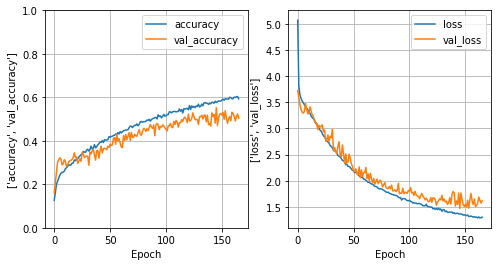

In [7]:
# Save model
model_name = 'googlenet_3'
model.save(f'models/{model_number}/{model_name}')

# Plot model statistics during training
kaggle.plot_model_history(history, [['accuracy', 'val_accuracy'], ['loss', 'val_loss']])

In [ ]:
# Fine-tune model
print('Fine-tuning model')
fine_model, history = kaggle.fine_tune_model_filepath(
    f'models/{model_number}/{model_name}',
    train_dataset.batch(128).cache(), valid_dataset, 
    epochs=5, learning_rate=0.00001)

In [15]:
# Save fine-tuned model
fine_model.save(f'models/{model_number}/googlenet_3_71')

INFO:tensorflow:Assets written to: models/model3/googlenet_3_71\assets


### Evaluate model

In [ ]:
model_to_evaluate = 'googlenet_3'
model = keras.models.load_model(f'models/{model_number}/{model_to_evaluate}')

test_pred_raw = model.predict(valid_dataset.batch(128))
test_pred = np.argmax(test_pred_raw, axis=1)

kaggle.print_accuracy(valid_labels, test_pred)
kaggle.plot_confusion_matrix(valid_labels, test_pred)

### Get labels for Kaggle

In [11]:
true_test_pred = np.argmax(model.predict(x_test_real), axis=1)

kaggle.save_test_pred(f'models/{model_number}/{model_to_evaluate}/{model_to_evaluate}_test_pred.csv', true_test_pred)